In [1]:
using LinearAlgebra, Plots, DifferentialEquations, ReverseDiff

In [445]:
w2 = 0.01
import NaNMath
g = 9.81

wind_x = 1.0

kpz = 5.0
kdz = 3.0
kpx = 1.0
kdx = 1.5
kpθ = 10.0
kdθ = 7.0
kff = -2/g

F(x) = [x[2];0;x[4];0;x[6];0]

G = zeros(6,3)
G[2,1] = 1.0
G[4,2] = 1.0
G[6,3] = 1.0

k(x,u,θ) = [-kpx*x[1] - kdx*x[2];
          -kpz*x[3] - kdz*x[4];
          -kpθ*x[5] - kdθ*x[6] + kpθ*u[4]#min(kff*min(0, u[4]), deg2rad(20))#-kpx*x[1] - kdx*x[2])  #- 1/θ[1]*(-sin(x[5])*(u[1] + u[2]) + cos(x[5])*u[3]))
          ]


Φ_θ_real(x::AbstractVector, u::AbstractVector) = [
  -sin(x[5])*(u[1] + u[2]) + cos(x[5])*u[3]    0;
  cos(x[5])*(u[1] + u[2]) + sin(x[5])*u[3]    0;
  0                                           u[1]-u[2];
]

Φ_θ(x::AbstractVector, u::AbstractVector) = [
  -sin(u[4])*(u[1] + u[2]) + cos(u[4])*u[3]    0;
  cos(u[4])*(u[1] + u[2]) + sin(u[4])*u[3]    0;
  0                                           u[1]-u[2];
]

Φ(x,u,θ) = Φ_θ(x,u)*θ + [0;-g;0] #+ [0*u[4]; 0*u[5]; 0.0]  # slack variables
Φ_real(x,u,θ) = Φ_θ_real(x,u)*θ + [0;-g;0]

function L(x::AbstractVector,u::AbstractVector,λ::AbstractVector, θ::AbstractVector)
  (
    0.5*dot(u[1:3], diagm([1.0, 1.0, 1.0])*u[1:3])                     # ½‖u‖²
  - w2*(NaNMath.log(u[1]*(-u[1] + 10)) + NaNMath.log(u[2]*(-u[2]+10)) + NaNMath.log(u[3]*(-u[3]+5)) + NaNMath.log((deg2rad(20)-u[4])^2))                     # log barrier
  + dot(λ, k(x,u,θ) - Φ(x,u,θ))           # dual term  ⟨λ, …⟩
  + 100*dot(u[4:end],u[4:end])                    # slack variables
  )
end
function L_flat(v, n_x, n_u, n_λ)
    x      = @view v[1:n_x]
    u      = @view v[n_x+1 : n_x+n_u]
    λ      = @view v[n_x+n_u+1 : n_x+n_u+n_λ]
    θ      = @view v[n_x+n_u+n_λ+1 : end]
    return L(x, u, λ, θ)
end

L_flat (generic function with 1 method)

In [446]:
x = zeros(6); n_x = length(x)
λ = ones(3); n_λ = length(λ)
u = ones(4); n_u = length(u)
θ = ones(2); n_θ = length(θ)
xhat = x

v = vcat(x, u, λ, θ)
f = v -> L_flat(v, n_x, n_u, n_λ)
tape = ReverseDiff.compile(ReverseDiff.HessianTape(f, v))

result = DiffResults.HessianResult(v)
result = ReverseDiff.hessian!(result, tape, vcat(x,u,λ,θ))
H = DiffResults.hessian(result)
H_uλ = H[n_x+1:n_x+n_u+n_λ, n_x+1:n_x+n_u+n_λ]
# invH = inv(H_uλ)


7×7 Matrix{Float64}:
  1.01012    0.0        0.0         1.38177    0.841471  -0.540302  -1.0
  0.0        1.01012    0.0         1.38177    0.841471  -0.540302   1.0
  0.0        0.0        1.01062     0.301169  -0.540302  -0.841471   0.0
  1.38177    1.38177    0.301169  200.827      1.92208    1.14264   10.0
  0.841471   0.841471  -0.540302    1.92208    0.0        0.0        0.0
 -0.540302  -0.540302  -0.841471    1.14264    0.0        0.0        0.0
 -1.0        1.0        0.0        10.0        0.0        0.0        0.0

In [454]:
θ_true = [1.0,10.0]


function uλθ_dot(x,u,λ,θ,ϵ, result)

    result = ReverseDiff.hessian!(result, tape, vcat(x,u,λ,θ))
    H = DiffResults.hessian(result)
    H_uλ = H[n_x+1:n_x+n_u+n_λ, n_x+1:n_x+n_u+n_λ]
    H_uλ_inv = inv(H_uλ)

    d2Ldxdudλ = H[n_x+1:n_x+n_u+n_λ,1:n_x]

    dLduλ = DiffResults.gradient(result)[n_x+1:n_x+n_u+n_λ]

    # term1 = -diagm([100,100,100.0, 100,100,100])*H_uλ_inv *dLduλ
    term1 = -100*H_uλ_inv *dLduλ

    θhat_dot = θ_dot(x, u, λ, θ, d2Ldxdudλ, dLduλ, ϵ)

    if LinearAlgebra.det(H_uλ[1:n_u,1:n_u]) < 0.001
        uff = zeros(n_u+n_λ)
    else

        d2Ldθdudλ = H[n_x+1:n_x+n_u+n_λ, n_x+n_u+n_λ+1:end]

        uff = H_uλ_inv * H_uλ_inv * (d2Ldxdudλ * (F(x) + G*Φ_real(x,u,θ)) + d2Ldθdudλ*θhat_dot)
    end
    
    udot = term1 - uff

    return vcat(udot, θhat_dot)
end

function θ_dot(x, u, λ, θ, d2Ldxdudλ, dLduλ, ϵ)
    Γ_θ_inv = diagm([0.01, 1.0])
    Γ_ϵ = 10*Matrix{Float64}(I, length(ϵ), length(ϵ))

    ϵ_0 = 0
    if norm(ϵ) < ϵ_0
        θdot = 0*θ
    else
        t1 = d2Ldxdudλ'*dLduλ
        t2 = Φ_θ_real(x,u)'*G'
        t3 = (Γ_ϵ*ϵ + t1)
        θdot = Γ_θ_inv*t2*t3
    end
    return θdot
end

function xhat_dot(xhat, x, u, θ)
    A = Matrix{Float64}(I, length(x), length(x))
    xhat_dot = A*(x-xhat) + F(x) + G*Φ_real(x,u,θ)
    return xhat_dot
end

function dudt(v,p,t)
    x = v[1:n_x]
    u      = v[n_x+1 : n_x+n_u]
    λ      = v[n_x+n_u+1 : n_x+n_u+n_λ]
    θ      = v[n_x+n_u+n_λ+1 : n_x+n_u+n_λ+n_θ]
    xhat   = v[n_x+n_u+n_λ+1+n_θ : end]
    ϵ = x - xhat
    duλθ      = uλθ_dot(x,u, λ, θ, ϵ, p)
    dx = F(x) + G*Φ_real(x,u,θ_true)
    dxhat = xhat_dot(xhat, x, u, θ)
    return vcat(dx, duλθ, dxhat)
end

x = zeros(6);
x[1] = -0.0
x[2] = 0.0
x[3] = -3.0
x[5] = deg2rad(0.0)  # Initial pitch angle
λ = zeros(3);
u = [0.01, 0.01, 0.1, 0.0];
θ = [1.5, 8.0];
xhat = x

result = DiffResults.HessianResult(vcat(x,u,λ,θ))

prob = ODEProblem(dudt, vcat(x, u, λ, θ, xhat), (0.0, 10.0),result)
# affect!(integrator) = integrator.u[1:n_x] .+= randn(n_x) * 0.0  # Random perturbation to state
# cb = PresetTimeCallback(1.0:0.1:9.0, affect!)
# sol = solve(prob, AutoTsit5(Rosenbrock23(autodiff = AutoFiniteDiff())))
sol = solve(prob, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 322-element Vector{Float64}:
  0.0
  6.323831445210398e-8
  6.956214589731437e-7
  2.605534390099329e-6
  5.829959099864796e-6
  1.0853038584160106e-5
  1.684706986431073e-5
  2.5259515944463036e-5
  3.691288726338222e-5
  5.437548061480557e-5
  ⋮
  9.74774696672486
  9.782785490318583
  9.817823956229551
  9.852862413327884
  9.887900908881418
  9.92293945757804
  9.957978188137279
  9.99301711070867
 10.0
u: 322-element Vector{Vector{Float64}}:
 [-0.0, 0.0, -3.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.1, 0.0  …  0.0, 0.0, 1.5, 8.0, -0.0, 0.0, -3.0, 0.0, 0.0, 0.0]
 [1.9995382311130271e-16, 6.323812582717259e-9, -3.0000000000000195, -6.191006736708428e-7, 1.1415127441291735e-20, 5.415073155042567e-13, 0.010039217743193564, 0.01003750528969058, 0.09999940349259244, 1.3874322124177795e-6  …  0.002568652223476026, 1.0726485530369358e-5, 1.4999999990722008, 8.0, 1.9995382311130271e-16, 9.485718771167271e-9, -3.000000000000

In [455]:
t_vec = 0:0.01:sol.t[end]
τ = zeros(3,length(t_vec))

L_vec = zeros(length(t_vec))

k_vec = zeros(3,length(t_vec))

FOO_vec = zeros(n_u+n_λ, length(t_vec))



for (j, t) in enumerate(t_vec)
    u = sol(t)[n_x+1:n_x+n_u]
    ϕ = Φ(sol(t)[1:n_x], u, θ_true)
    θ = sol(t)[n_x+n_u+n_λ+1:n_x+n_u+n_λ+n_θ]
    τ[:,j] = ϕ
    L_vec[j] = L_flat(sol(t)[1:end-n_x], n_x, n_u, n_λ)
    k_vec[:,j] = k(sol(t)[1:n_x], u, θ)
    FOO_vec[:,j] = ReverseDiff.gradient(f, sol(t)[1:end-n_x])[n_x+1:n_x+n_u+n_λ]

end



In [ ]:
# Calculate persistence of excitation integral
PE_matrix = zeros(n_θ, n_θ)
PE_cumulative = zeros(length(t_vec), n_θ)
PE_running = zeros(n_θ, n_θ)

# Calculate PE matrix and track cumulative eigenvalues
for (j, t) in enumerate(t_vec)
    x = sol(t)[1:n_x]
    u = sol(t)[n_x+1:n_x+n_u]
    ϕ = G*Φ_θ(x, u)
    PE_running += ϕ'*ϕ * 0.1  # Multiply by time step for proper integration
    PE_cumulative[j, :] = eigvals(PE_running)
end

PE_matrix = PE_running  # Final integrated value

# Check if persistently exciting
eigenvalues = eigvals(PE_matrix)
is_PE = all(eigenvalues .> 1e-6)
println("Persistence of excitation check:")
println("PE integral eigenvalues: ", eigenvalues)
println("System is persistently exciting: ", is_PE)

# Plot the evolution of eigenvalues over time to visualize PE
plot(t_vec, PE_cumulative, xlabel="Time", ylabel="Eigenvalues",
     label=["λ₁" "λ₂" "λ₃"], title="PE Matrix Eigenvalues Over Time")

┌ Info: Saved animation to /home/dmrc/git/vtol-adaptive-control/vtol_animation.gif
└ @ Plots /home/dmrc/.julia/packages/Plots/uiCPf/src/animation.jl:156


Plots.AnimatedGif("/home/dmrc/git/vtol-adaptive-control/vtol_animation.gif")
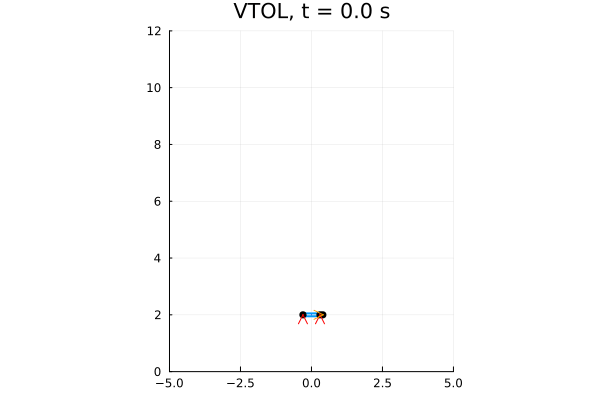

In [461]:
include("animation.jl")
animate_vtol(sol)

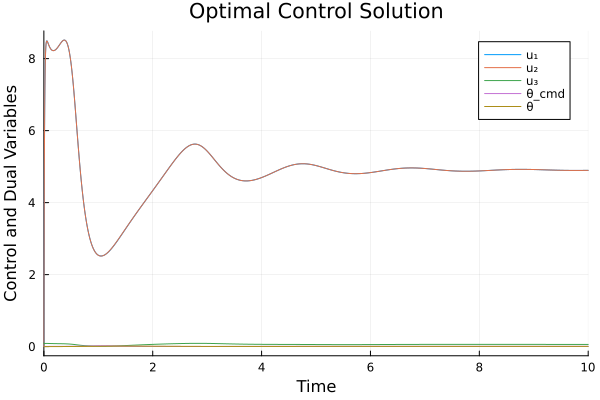

In [456]:
plot(sol, idxs=(0, vcat(n_x+1:n_x+n_u, 5)), xlabel="Time", ylabel="Control and Dual Variables",
     label=["u₁" "u₂" "u₃" "θ_cmd" "θ"], title="Optimal Control Solution")

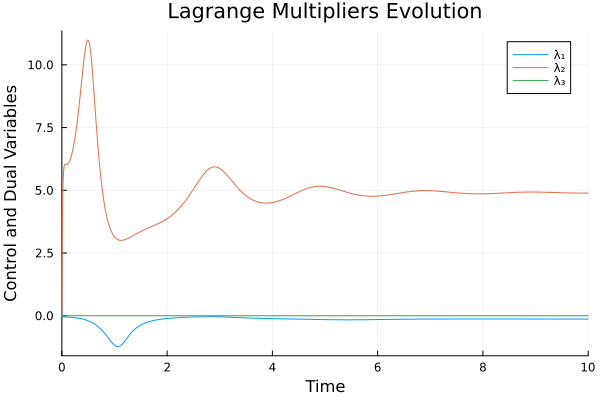

In [457]:
plot(sol, idxs= (0,n_x+n_u+1:n_x+n_u+n_λ), xlabel="Time", ylabel="Control and Dual Variables",
     label=["λ₁" "λ₂" "λ₃"], title="Lagrange Multipliers Evolution")

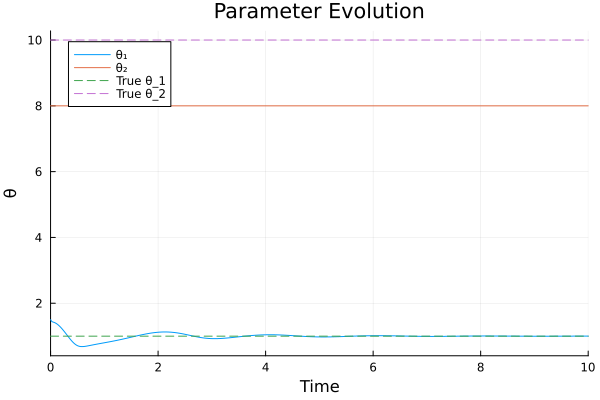

In [458]:
plot(sol, idxs=(0, n_x+n_u+n_λ+1:n_x+n_u+n_λ+n_θ), xlabel="Time", ylabel="θ",
     label=["θ₁" "θ₂"], title="Parameter Evolution")
for i in 1:n_θ
    plot!(t_vec, fill(θ_true[i], length(t_vec)), label="True θ_$i", linestyle=:dash)
end
plot!()

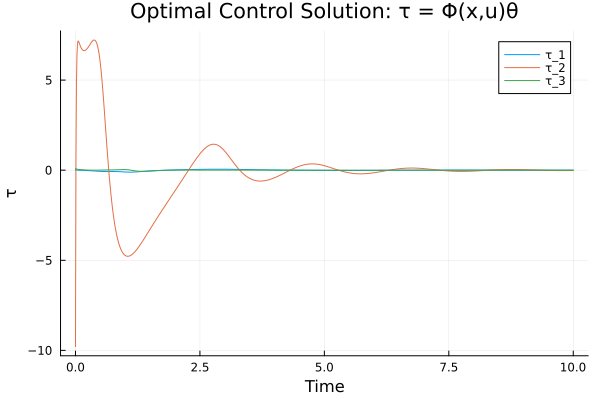

In [459]:
plot(t_vec, τ', label=["τ_1" "τ_2" "τ_3"], xlabel="Time", ylabel="τ",
     title="Optimal Control Solution: τ = Φ(x,u)θ")

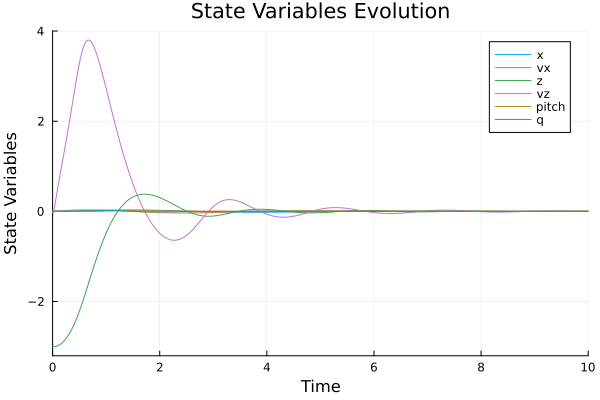

In [460]:
plot(sol, idxs= (0,[1,2,3,4,5,6]), xlabel="Time", ylabel="State Variables",
     label=["x" "vx" "z" "vz" "pitch" "q"], title="State Variables Evolution")

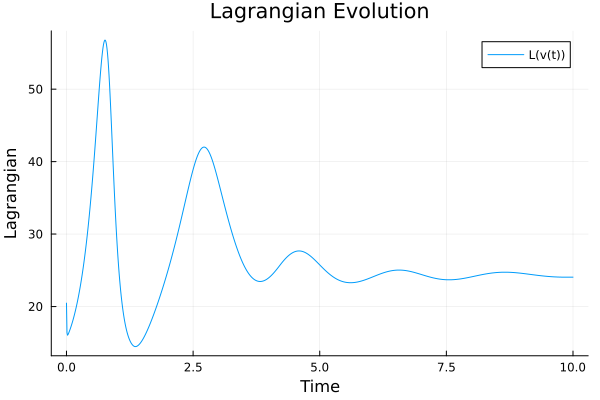

In [431]:
plot(t_vec, L_vec, xlabel="Time", ylabel="Lagrangian",
     title="Lagrangian Evolution", label="L(v(t))")

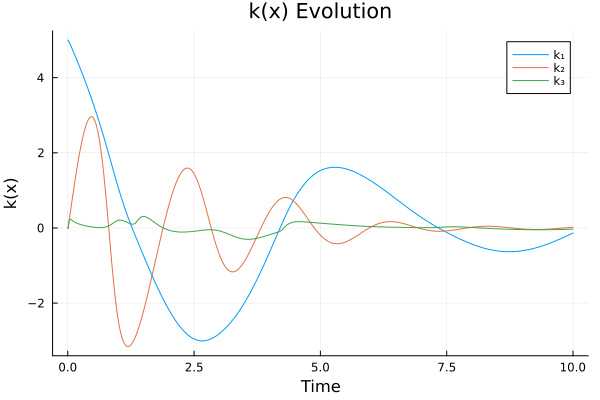

In [430]:
plot(t_vec, k_vec', label=["k₁" "k₂" "k₃"], xlabel="Time", ylabel="k(x)",
     title="k(x) Evolution")

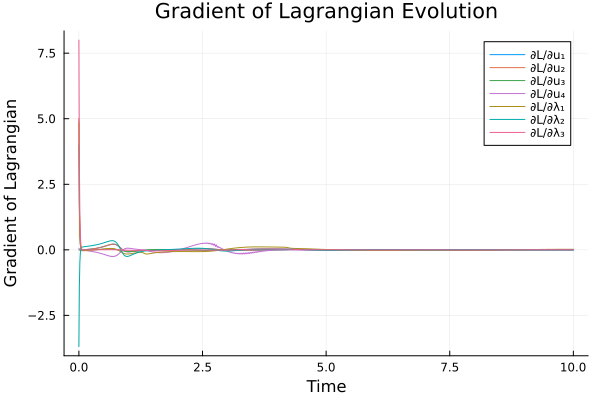

In [426]:
plot(t_vec, FOO_vec', label=["∂L/∂u₁" "∂L/∂u₂" "∂L/∂u₃" "∂L/∂u₄" "∂L/∂λ₁" "∂L/∂λ₂" "∂L/∂λ₃"],
     xlabel="Time", ylabel="Gradient of Lagrangian",
     title="Gradient of Lagrangian Evolution")